In [39]:
from solve_rg_eqs import solve_Gs_list, G_to_g, unpack_dims, bootstrap_g0
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import seaborn as sns

# New run

## Setup
First, let's set physical parameters.

In [2]:
l = 6
L = 2*l
N = l
Ne = N//2
if N <= 2*l: # below half-filling
    Nws = np.arange(0, Ne+1, 1) # Not going to check Nw > Ne because that's for Sz > 0
else:
    # above half filling
    # Can fit at most L spin down fermions, L spin up
    # Nw = Ne + Sz = Ne + .5(Nup - Ndown)
    # max(Ndown) = 2*L
    # min(Sz) = .5((N-L) - L) = .5*(N - 4*L)
    min_Nw = Ne + (N-4*l)//2
    Nws = np.arange(min_Nw, Ne+1, 1)
Nws = [2]
print(Nws)
k = np.arange(1, 2*l+1, 2)*0.5*np.pi/l
Grs = np.arange(.1, 2.1, .1)
Grs = Grs[Grs != 1]
Gs = Grs/np.sum(k)
print(Gs*np.sum(k))

[2]
[0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.1 1.2 1.3 1.4 1.5 1.6 1.7 1.8 1.9
 2. ]


Now, let's set numerical parameters. These can be sensitive.

In [3]:
dg = 0.1/L # step size of g.
g0 = dg/L # initial value of g
imk = dg # scale of the imaginary parts added to k
imv = g0/L # scale of the imaginary parts used in the initial guess

skip=N # it's harder for larger N, so let's make it easy on us

## Solving RG equations
Now, we solve the RG equations for each value of Nw (representing different polarizations).
We can calculate energy with different fields afterwards to find which polarization minimizes energy in each situation.

In [4]:
ki = (-1)**np.arange(l)*imk
kc = np.concatenate((k, ki))
outputs = []
for Nw in Nws:
    dims = (l, Ne, Nw)
    sol = bootstrap_g0(dims, g0, kc, imscale_v=imv)
    outputs += [solve_Gs_list(dims, sol, Gs, k, dg=dg, g0=g0, imscale_k=imk, imscale_v=imv)]

Forming guess with Nei, Nwi 
(2, 2)
Guess vars
[0.26175179+0.00833587j 0.26175179+0.00832777j]
[0.26178352+0.00814764j 0.26178352+0.00851801j]

Now using 4 fermions
Ne, Nw = (2, 2)

Variable guess
[0.26175179+0.00833587j 0.26175179+0.00832777j]
[0.26178352+0.00814764j 0.26178352+0.00851801j]
Omega = 0 solution! Rerunning.
Bad initial guess. Trying with noise.
g = 0.0006944444444444445, er = 1
1th try at g = 0.0006944444444444445
Smallest error from last set: 1
Noise ranges from -4.8372571703866706e-05 to 1.0565895189053967e-05
Error with 4 fermions: 6.631533478216076e-13
1

Now using 6 fermions
Ne, Nw = (3, 2)

Variable guess
[0.26168681+0.00832616j 0.26176921+0.00833141j 0.7849698 -0.00832528j]
[0.26172952+0.00830499j 0.26172649+0.00835257j]
Error with 6 fermions: 9.62548559376349e-13
Incrementing from 0.0006944444444444445 to 0.15915494309189532
Removing im(k) at g = 0.009027777777777777
s = 1.0
s = 0.9
s = 0.8
s = 0.7000000000000001
s = 0.6000000000000001
s = 0.5000000000000001
s = 

# Wavefunction coefficients

## $Ne = 3, N_\omega = 2$

(19, 3)


/Users/wholdhus/Desktop/repos/so5-richardson-gaudin/utils.py:16: ComplexWarning: Casting complex values to real discards the imaginary part
  return fsum(prod(a[i][sigma[i]] for i in r) for sigma in s)


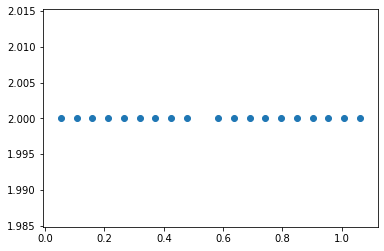

In [27]:
plt.scatter(df['G']*np.sum(k), ((C111s/C000s)))

In [ ]:
plt.scatter(df['G']*np.sum(k), df['energy'])

In [ ]:
for i in range(len(df)):
    Ninds = ['N_{}'.format(i) for i in range(l)]
    plt.scatter(k, df[Ninds].iloc[i])

# Energies with magnetic field

In [ ]:
h = 0 # Sanity check
for i, o in enumerate(outputs):
    Sz = Nws[i] - Ne
    print('Total Sz:')
    print(Sz)
    print(o['energy'].iloc[-1] + h * Sz)

In [ ]:
h = .5 # so spin-down has lower energy
for i, o in enumerate(outputs):
    Sz = Nws[i] - Ne
    print('Total Sz:')
    print(Sz)
    print(o['energy'].iloc[-1] + h * Sz)

In [ ]:
plt.figure(figsize=(4,4), dpi=400)
h = .5
for i, o in enumerate(outputs):
    Sz = Nws[i] - Ne
    print('Total Sz:')
    print(Sz)
    plt.plot(o['G']*np.sum(k), o['energy'] + h*Sz, label='Sz = {}'.format(Sz))
plt.legend()

In [ ]:
import pickle


In [ ]:
l = 20
Ne = 20
filen = 'pol_results_Ne{}.p'.format(Ne)
pickle.dump(outputs, open(filen, 'wb'))
outputs = pickle.load(open(filen, 'rb'))
hs = np.arange(0, 1.1, .1)
Szs = Nws - Ne
print(Szs)
# mags = np.zeros((len(hs), len(outputs[0]['G'])))
mags = pd.DataFrame({})
for n, h in enumerate(hs):
    mags_h = np.zeros(len(outputs[0]['G']))
    for i, G in enumerate(outputs[0]['G']):
        energies = [outputs[j]['energy'].iloc[i] + h * Szs[j] for j in range(len(outputs))]
        min_Ne_ind = np.argmin((energies))
        mags_h[i] = Szs[min_Ne_ind]
    mags[np.round(h, 2)] = mags_h
    
plt.figure(figsize=(8,8), dpi=400)
yticks = [np.round(G*np.sum(k), 1) for G in outputs[0]['G']]
for i in range(len(yticks)):
    if i%2 == 0:
        yticks[i] = None

sns.heatmap(mags, yticklabels=yticks)

# mags = np.zeros((len(hs), len(outputs[0]['G'])))
mags = pd.DataFrame({})
for i, G in enumerate(outputs[0]['G']):
    mags_h = np.zeros(len(hs))
    for j, h in enumerate(hs):
        energies = [outputs[k]['energy'].iloc[i] + h * Szs[k] for k in range(len(outputs))]
        min_Ne_ind = np.argmin((energies))
        mags_h[j] = Szs[min_Ne_ind]
    mags[np.round(G*np.sum(k), 2)] = mags_h
plt.figure(figsize=(8,8), dpi=400)
yticks = np.round(hs, 1)
sns.heatmap(mags), # yticklabels=yticks)

plt.figure(figsize=(3,3), dpi=400)
for i, G in enumerate(mags):
    if i % 4 == 0:
        plt.plot(hs, mags[G], label = r'$G/G_c$= {}'.format(np.round(G, 1)))
# plt.legend()

In [ ]:
from exact_diag import spinful_fermion_basis_1d, ham_op_2
from exact_diag import casimir_dict, quantum_operator


In [ ]:
df_ind = 0
G = outputs[0]['G'].iloc[df_ind]
print(G*np.sum(k))
for i, Nw in enumerate(Nws):
    print('')
    Sz = Nw - Ne
    print('Sz')
    print(Sz)
    Nup = int(2*Sz + N)//2
    Ndwn = N - Nup
    print(Nup)
    print(Ndwn)
    basis = spinful_fermion_basis_1d(L, Nf = (Nup, Ndwn))
    H = ham_op_2(l, G, k, basis)
    e, v = H.eigh()
    print('ED energy')
    print(e[0])
    print('ED casimirs')
    for j in range(l):
        c = quantum_operator(casimir_dict(l, j, 1), basis=basis, check_pcon=False, check_herm=False, check_symm=False)
        print(c.matrix_ele(v[:,0], v[:,0]))
    print('RG energy')
    print(outputs[i]['energy'].iloc[df_ind])

In [ ]:
df_ind = 3
G = outputs[0]['G'].iloc[df_ind]
print(G*np.sum(k))
for i, Nw in enumerate(Nws):
    print('')
    Sz = Nw - Ne
    print('Sz')
    print(Sz)
    Nup = int(2*Sz + N)//2
    Ndwn = N - Nup
    print(Nup)
    print(Ndwn)
    basis = spinful_fermion_basis_1d(L, Nf = (Nup, Ndwn))
    H = ham_op_2(l, G, k, basis)
    e, v = H.eigh()
    print('ED energies')
    print(e[0])
    print('ED casimirs')
    for j in range(l):
        c = quantum_operator(casimir_dict(l, j, 1), basis=basis, check_pcon=False, check_herm=False, check_symm=False)
        print(c.matrix_ele(v[:,0], v[:,0]))
    print('RG energy')
    print(outputs[i]['energy'].iloc[df_ind])

In [ ]:
df_ind = 5
G = outputs[0]['G'].iloc[df_ind]
print(G*np.sum(k))
for i, Nw in enumerate(Nws):
    print('')
    Sz = Nw - Ne
    print('Sz')
    print(Sz)
    Nup = int(2*Sz + N)//2
    Ndwn = N - Nup
    print(Nup)
    print(Ndwn)
    basis = spinful_fermion_basis_1d(L, Nf = (Nup, Ndwn))
    H = ham_op_2(l, G, k, basis)
    e, v = H.eigh()
    print('ED energies')
    print(e[0])
    print('ED casimirs')
    for j in range(l):
        c = quantum_operator(casimir_dict(l, j, 1), basis=basis, check_pcon=False, check_herm=False, check_symm=False)
        print(c.matrix_ele(v[:,0], v[:,0]))
    print('RG energy')
    print(outputs[i]['energy'].iloc[df_ind])

In [ ]:
df_ind = -1
G = outputs[0]['G'].iloc[df_ind]
print(G*np.sum(k))
for i, Nw in enumerate(Nws):
    print('')
    Sz = Nw - Ne
    print('Sz')
    print(Sz)
    Nup = int(2*Sz + N)//2
    Ndwn = N - Nup
    print(Nup)
    print(Ndwn)
    basis = spinful_fermion_basis_1d(L, Nf = (Nup, Ndwn))
    H = ham_op_2(l, G, k, basis)
    e, v = H.eigh()
    print('ED energies')
    print(e[0])
    print('ED casimirs')
    for j in range(l):
        c = quantum_operator(casimir_dict(l, j, 1), basis=basis, check_pcon=False, check_herm=False, check_symm=False)
        print(c.matrix_ele(v[:,0], v[:,0]))
    print('RG energy')
    print(outputs[i]['energy'].iloc[df_ind])